# D9 Recreating  W E B Du Bois Visualisation
---
### Thirty days of Data Visualisations
JWriggy

Inspired by a [challenge](https://github.com/ajstarks/dubois-data-portraits/tree/master/challenge) to recreate some of Du Bois's classic visualisations.

This could do with a few refinements - eg to arrows. But normalising lengths whilst projecting into a different coordinate system eludes me for the moment. Cartopy, geopandas and natural earth data used here for the maps.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
# for maps
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import geopandas

import numpy as np

plt.style.use('db.mplstyle')

In [2]:
# The Data
# found a couple of inconsistencies with the dataset provided as part of the challenge - 
# eg duplicate state codes and codes that didn't match the original vis. Treat data with caution.
df1 = pd.read_csv('data/Dubois9.csv', index_col="State")
df2 = pd.read_csv('data/Dubois9b.csv', index_col="State")
df1.head()

,Birthplace
State,
NM,1
OK,9
AR,37
LA,144
TX,99


In [3]:
states_shp = shpreader.natural_earth(resolution='110m',
                                category='cultural', 
                                name='admin_1_states_provinces_lakes_shp')
statesdf = geopandas.read_file(states_shp)

# set up geopandas dataframe of required fields for plotting
states = statesdf[['name','postal','geometry']]
states = states.set_index('postal') # 2 char code to match dataset
states.head(2)

,name,geometry
postal,,
MN,Minnesota,"POLYGON ((-92.01192 46.71172, -92.27488 46.656..."
MT,Montana,"POLYGON ((-104.02662 45.95660, -104.07796 45.0..."


In [4]:
georgiaX = -82.9 # lon
georgiaY = 32.166 #lat

# birthplace data
bp = states.join(df1, how='inner')
bp['centroid'] = bp.centroid
# for arrows 
bpX = bp.centroid.x.values
bpY = bp.centroid.y.values
bpU = georgiaX - bpX  
bpV = georgiaY - bpY 
bp.head()

,name,geometry,Birthplace,centroid
MN,Minnesota,"POLYGON ((-92.01192 46.71172, -92.27488 46.656...",4,POINT (-94.29617 46.32478)
ID,Idaho,"POLYGON ((-111.08518 44.50615, -111.04973 44.4...",1,POINT (-114.65497 44.39401)
NM,New Mexico,"POLYGON ((-103.00322 36.99516, -103.00161 36.4...",1,POINT (-106.08613 34.41656)
OR,Oregon,"POLYGON ((-116.91500 45.99998, -116.67900 45.8...",1,POINT (-120.53933 43.94483)
UT,Utah,"POLYGON ((-109.05318 41.00199, -109.04522 36.9...",1,POINT (-111.66920 39.32876)


In [5]:
# present location data
pl = states.join(df2, how='inner')
pl['centroid'] = pl.centroid
# for arrows
plX = pl.centroid.x.values
plY = pl.centroid.y.values
plU = plX - georgiaX
plV = plY - georgiaY 
pl.head()

,name,geometry,Present Location,centroid
MN,Minnesota,"POLYGON ((-92.01192 46.71172, -92.27488 46.656...",62,POINT (-94.29617 46.32478)
MT,Montana,"POLYGON ((-104.02662 45.95660, -104.07796 45.0...",38,POINT (-109.65900 47.04846)
ND,North Dakota,"POLYGON ((-97.22894 49.00089, -97.21414 48.902...",5,POINT (-100.48470 47.46271)
ID,Idaho,"POLYGON ((-111.08518 44.50615, -111.04973 44.4...",7,POINT (-114.65497 44.39401)
WA,Washington,"POLYGON ((-117.03143 48.99931, -117.02665 47.7...",44,POINT (-120.39837 47.37975)


In [6]:
# checking dataset manipulation
assert bp.loc['OK','Birthplace'] == 9
assert pl.loc['CA','Present Location'] == 254

In [7]:
# text
title = 'MIGRATION OF NEGROES.\n1890'
label1 = 'PRESENT DWELLING PLACE OF NEGROES BORN IN GEORGIA.'
label2 = 'BIRTH PLACE OF NEGROES NOW PRESENT IN GEORGIA'

# style
ec = '#666666'
h2 = {'fontsize': 10, 'alpha': 0.6,  'ha':'center', 'va':'center'}

# colours similar to Du Bois vis
# as far as I can tell the colours are random
states['colour'] = '#dddddd'
states.loc['GA','colour'] = '#000000' # georgia
states.loc[['CA','CT','WY','OK','IL','FL','ME','MD'],'colour'] = '#ffd700' # y
states.loc[['MT','KS','AL','VA'],'colour'] = '#669966' # g
states.loc[['CO','AR','PA','OR','RI'],'colour'] = '#dc143c' # r
states.loc[['ID','AZ','WI','SC','NY','MO'],'colour'] = '#4682b4' # b
states.loc[['NV','NE','MN','OK','LA','IN','NC','VT'],'colour'] = '#ffc0cb' # p
states.loc[['NM','ND','MS','OH','MA'],'colour'] = '#d2b48c' # tan
states.loc[['UT','SD','MI','TN','WV'],'colour'] = '#987654' # br

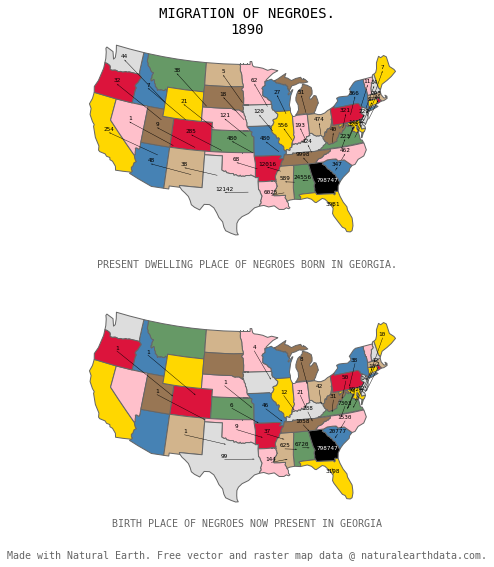

In [8]:
import matplotlib.path as mpath
import matplotlib.patches as mpatches

ax_crs = ccrs.LambertConformal()
#ax_crs =  ccrs.PlateCarree(central_longitude=-96.5)
data_crs = ccrs.PlateCarree()

fig = plt.figure(figsize=(8,8))

## Present Location
geoax1 = plt.subplot(211, projection=ax_crs)
geoax1.set_extent([-125, -66.5, 20, 50],ccrs.Geodetic())
geoax1.set_frame_on(False)

# plot states
for ix,state in states.iterrows():
        geoax1.add_geometries([state.geometry], data_crs,facecolor=state.colour, edgecolor=ec)
# annotate
geoax1.quiver(plX, plY, plU, plV, pivot='tip', width=.001, zorder=5, transform=data_crs)
for ix, row in pl.iterrows():
        geoax1.text(row.centroid.x, row.centroid.y+.3,row['Present Location'], 
                    ha='center',fontsize=6,transform=data_crs)
# Georgia
geoax1.text(-82.9,32.166,pl.at['GA','Present Location'],color='w',ha='center',fontsize=6,transform=data_crs)

## Birthplace
geoax2 = plt.subplot(212, projection=ax_crs)
geoax2.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())
geoax2.set_frame_on(False)

# plot states
for ix,state in states.iterrows():
        geoax2.add_geometries([state.geometry], data_crs,facecolor=state.colour, edgecolor=ec)  
# annotate
geoax2.quiver(bpX, bpY, bpU, bpV, width=.001,zorder=5, transform=data_crs) ###
for ix, row in bp.iterrows():
        geoax2.text(row.centroid.x, row.centroid.y+.3,row['Birthplace'], ha='center',fontsize=6,transform=data_crs)
# Georgia
geoax2.text(-82.9,32.166,bp.at['GA','Birthplace'],color='w',ha='center', fontsize=6,transform=data_crs)

fig.subplots_adjust(bottom=0.1, top=0.95,left=0.05, right=0.95, wspace=0.02)
fig.text(0.5,0.95,title, fontsize=14, ha='center')
fig.text(0.5,0.55,label1, fontdict=h2)
fig.text(0.5,0.1,label2, fontdict=h2)
fig.text(.5,.04,"Made with Natural Earth. Free vector and raster map data @ naturalearthdata.com.", alpha=0.6, ha='center') 
plt.savefig("vis/D9_duBois9.png")
plt.show()